# Planning Report — Predicting Usage of a Video Game Research Server
**Student:** Ansh Taparia 

**Project:** UBC Data Science Project  
**Student ID:** 32652604 

This notebook is fully reproducible.


In [93]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
set.seed(160)
options(repr.matrix.max.rows = 6)

In [94]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

players 
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## Data Description

The dataset `players.csv` contains one row per player and describes individual player characteristics and activity levels in the game. 

Each player has information such as:
- **experience** – the player’s skill level or familiarity with the game (Amateur, Veteran, or Pro).  
- **subscribe** – whether the player subscribed to the newsletter (TRUE/FALSE), which is our **response variable**.  
- **hashedEmail** – a unique player ID.  
- **played_hours** – the total number of hours each player has spent in the game.  
- **name** 
- **gender**  
- **Age**
 
We are only using the `players.csv` dataset and not the `sessions.csv`.  
By looking at how the **mean**, **standard deviation (sd)**, and **median** of the two
numerical variables — `Age` and `played_hours`, we describe the overall player base.

In [95]:
ph <- players |>
  summarise(
    mean = round(mean(played_hours, na.rm = TRUE), 2),
    median = round(median(played_hours, na.rm = TRUE), 2),
    sd = round(sd(played_hours, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "value") |>
  mutate(variable = "played_hours")

ag <- players |>
  summarise(
    mean = round(mean(Age, na.rm = TRUE), 2),
    median = round(median(Age, na.rm = TRUE), 2),
    sd = round(sd(Age, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "value") |>
  mutate(variable = "Age")

players_stats <- rbind(ph, ag) |>
  arrange(variable, stat)

players_stats

stat,value,variable
<chr>,<dbl>,<chr>
mean,21.14,Age
median,19.00,Age
sd,7.39,Age
mean,5.85,played_hours
median,0.10,played_hours
sd,28.36,played_hours


## Questions

**Broad question:**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question (players.csv only):**  
Can a player’s **experience**, **Age**, **gender**, and **played_hours** predict whether they **subscribe** to the newsletter?  

How do these features differ between **experience** groups (Amateur, Veteran, Pro)?

## Exploratory Data Analysis (EDA)

I explore three key visualizations that connect player traits to subscription status:

1. **Subscription Rate by Experience:**  
   This shows how likely different player types (Amateur, Veteran, Pro) are to subscribe.  

2. **Played Hours by Subscription:**  
   This illustrates that players who have higher hours played are more likely to subscribe.   

3. **Age vs. Played Hours, Coloured by Subscription:**  
   This explores whether both age and playtime together influence who subscribes.  

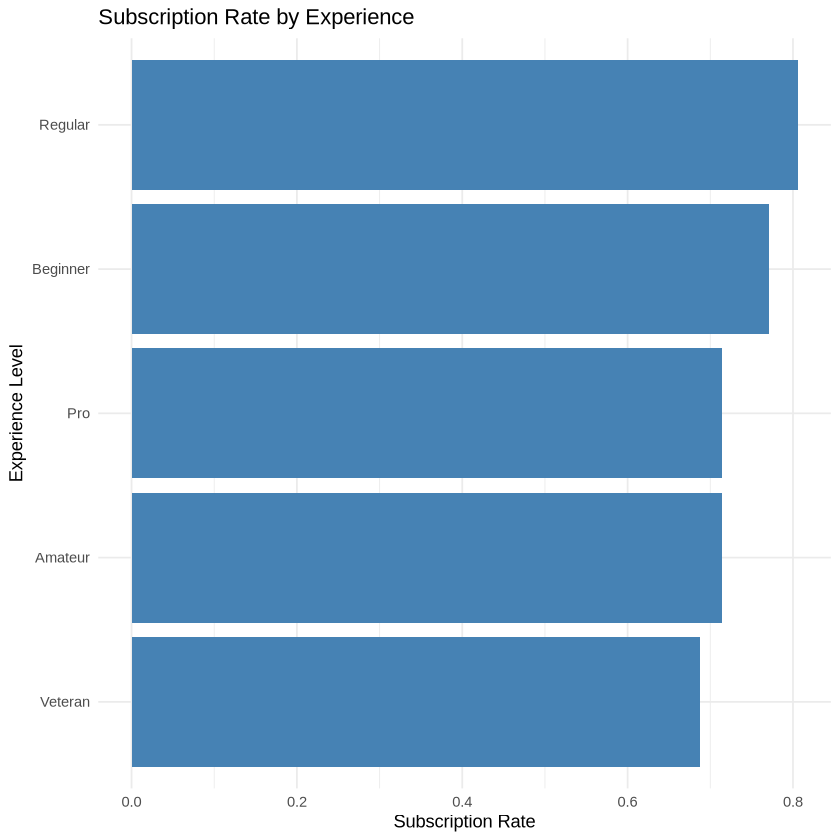

In [103]:
rate_by_exp <- players |>
  group_by(experience) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE))

ggplot(rate_by_exp, aes(x = reorder(experience, sub_rate), y = sub_rate)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Subscription Rate by Experience",
       x = "Experience Level",
       y = "Subscription Rate") +
  theme_minimal()


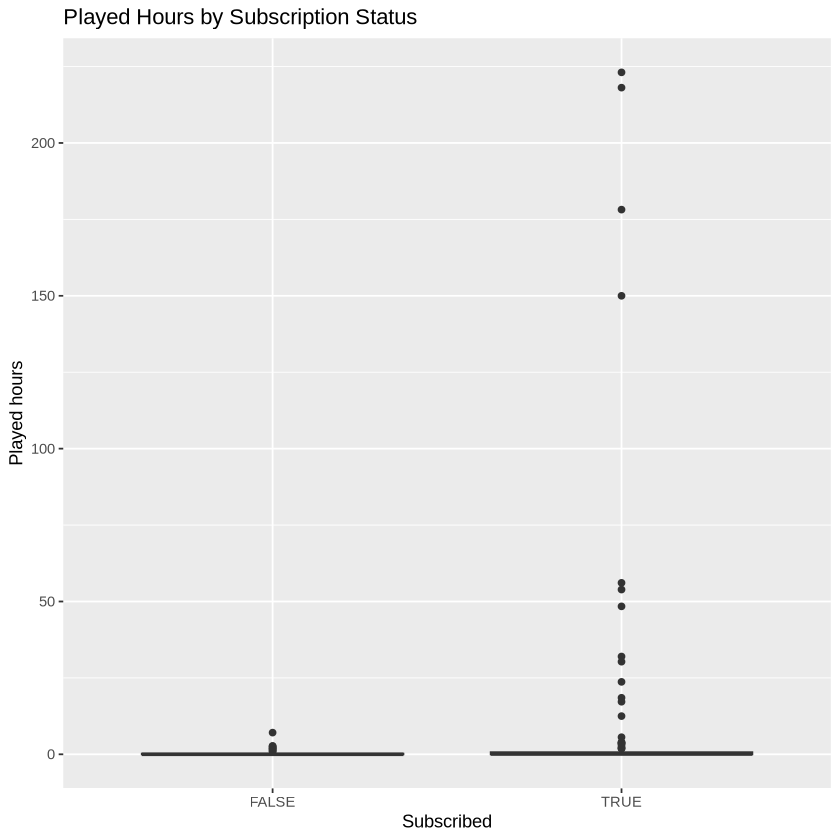

In [104]:
ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(title = "Played Hours by Subscription Status",
       x = "Subscribed", y = "Played hours")

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


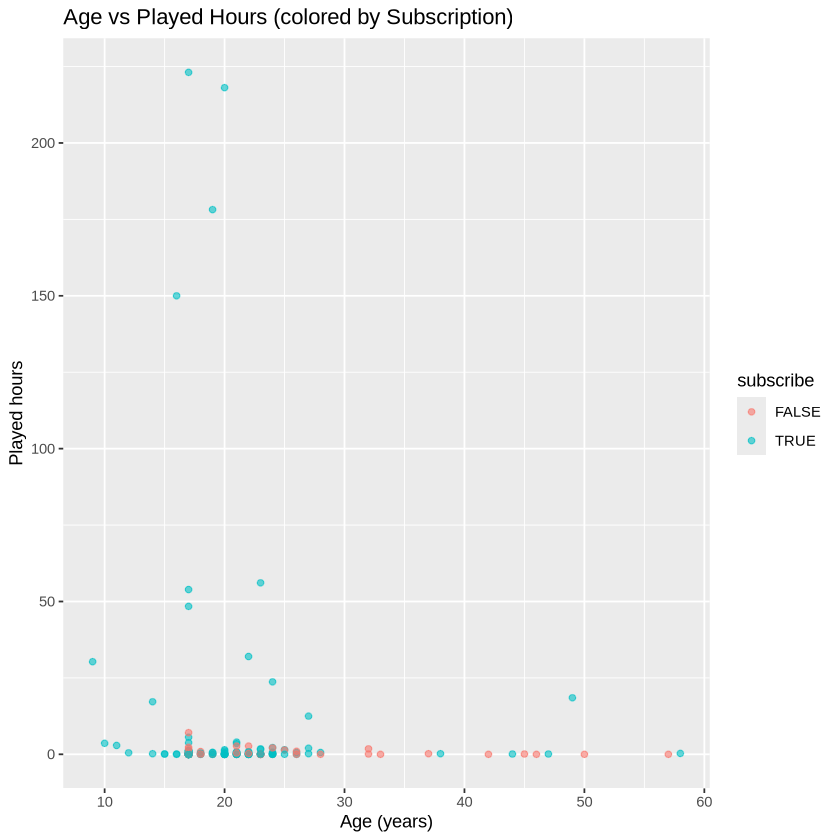

In [105]:
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Age vs Played Hours (colored by Subscription)",
       x = "Age (years)", y = "Played hours")

### Insights

From these plots, several trends appear:
- **Experienced players** (Veterans and Pros) represent far more subscribers compared to Amateurs.  
-  **Subscribers** generally spend more hours playing than non-subscribers, suggesting engagement predicts interest in the newsletter.
-  It can be seen from the scatterplot that **younger and middle-aged players** who spend more time in the game are likely to subscribe, while less active or older players are less represented among subscribers.



## Methods and Plan

**Objective:** Use features in `players.csv` to predict whether a player subscribes to the newsletter (TRUE/FALSE).`.

**Method:** Logistic Regression (classification).

**Response:** `subscribe`  
**Predictors:** `experience`, `gender`, `Age`, `played_hours`

**Why this method?**  
Logistic regression is chosen because it models a binary outcome and is easy to interpret. It estimates the probability that a player subscribes based on their characteristics, while keeping the model simple. 

**Key assumptions.**  
This technique essentially assumes independence of each observation-that there is a linear relationship between the independent variables and the log-odds of the outcome. It assumes independence among the independent variables themselves, that is, not too highly correlated.

**Limitations.**  
A couple of limitations - like gaps in the Age field - will affect the model by shrinking usable data. On top of that, the `played_hours` feature is right-skewed; certain users clock way more hours than most, potentially throwing off predictions.

**How the model will be compared and selected.**  
Before fitting the model, numeric predictors like `age` and `played hours` will first be standardized to put them on similar scales. This standardizes the data so that no one variable will have more impact on a model simply by virtue of having larger numeric values.

**How the data will be processed to apply the model.**  
I'll prepare the data before fitting the model by converting categorical variables into factor types and imputing missing age values with the median. To avoid data leakage, imputation will be done inside the training set in the course of cross-validation. The dataset will then be split into a training and a testing set. In case the subscription variable is unbalanced, use a stratified split to make sure both classes are fairly represented in both subsets.

## Word Count 

**Word Count** : 546